In [1]:
import sys
# sys.path.append('....')
# sys.path.append('lib/src/')
# sys.path.append('riemannian_random_walk.models/')
sys.path.append('../../..')
sys.path.append('../../../lib/src/')
sys.path.append('../../../TopographicVAE-master')

import torch
from torch import nn
from itertools import islice
import os
import numpy as np
from matplotlib import pyplot as plt


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_ColorMNIST, Decoder_ColorMNIST,Encoder_Chairs, Decoder_Chairs, My_MaskedDataset
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback


from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling


from riemannian_random_walk.models.generation import hmc_manifold_sampling, random_walk_batch

from tvae.data.mnist import DualTransformPreprocessor, PersepctivePreprocessor, Preprocessor
from tvae.utils.logging import get_dirs



def plot_sequence(grid, color=True):
    NUM_SEQ = grid.shape[0]
    NUM_FRAMES = grid.shape[1]

    fig, axs = plt.subplots(NUM_SEQ, NUM_FRAMES, figsize=(NUM_FRAMES, NUM_SEQ))
    if NUM_SEQ == 1:
        axs = axs[None, :]
    for i in range(NUM_SEQ):
        for j in range(NUM_FRAMES):
            axs[i, j].imshow(grid[i, j].cpu().detach().permute(1, 2, 0), cmap='gray' if not color else None)
            axs[i, j].axis('off')
    
    plt.show()

def extract_dataset(loader, c = 3, h = 28, w = 28):
    dataset = []

    for data, label in loader:
        data = data.squeeze(2,3) #(32, 18, 3, 28, 28)
        data = data.reshape(-1, c, h, w)
        dataset.append(data)
    
    dataset = torch.cat(dataset, 0)
    return dataset
    

%reload_ext autoreload
%autoreload 2
!nvidia-smi

Thu Aug  1 15:53:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   36C    P8             10W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

torch.Size([64000, 3, 28, 28])
torch.Size([32000, 3, 28, 28])
torch.Size([10, 8, 3, 28, 28])


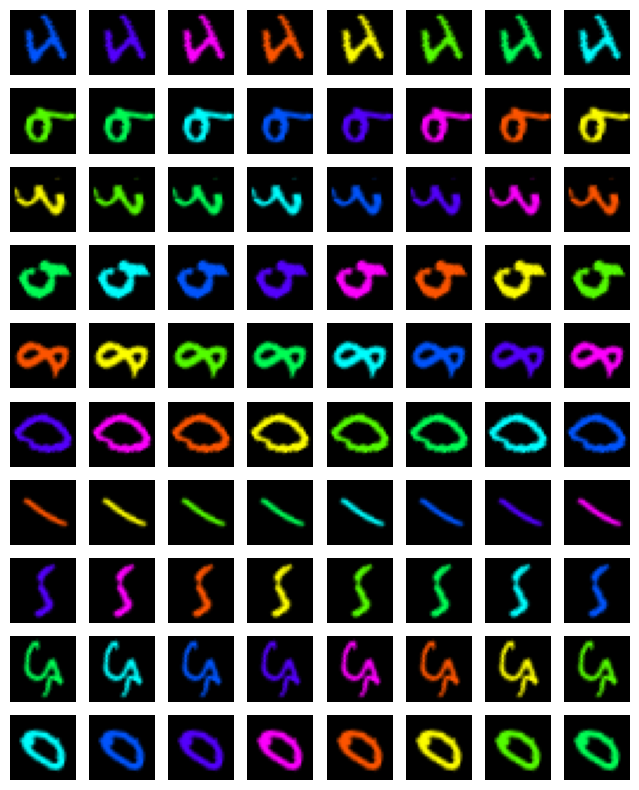

In [17]:
#ROTCOLOR MNIST
# config = {
#     'wandb_on': False,
#     'lr': 1e-4,
#     'momentum': 0.9,
#     ########################
#     'batch_size': 32,
#     ########################
#     'max_epochs': 100,
#     'eval_epochs': 5,
#     'dataset': 'MNIST',
#     'train_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_angle_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340', 
#     'train_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'test_color_set': '0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340',
#     'train_scale_set': '1.0',
#     'test_scale_set': '1.0',
#     'pct_val': 0.2,
#     'random_crop': 28,
#     'seed': 1,
#     'n_caps': 18,
#     'cap_dim': 18,
#     'n_transforms': 18,
#     'mu_init': 30.0,
#     'n_off_diag': 1,
#     'group_kernel': (13, 13, 1),
#     'train_eq_loss': False,
#     'n_is_samples': 10
#     }

config = {
    'wandb_on': False,
    'lr': 1e-4,
    'momentum': 0.9,
    ########################
    'batch_size': 32,
    ########################
    'max_epochs': 100,
    'eval_epochs': 5,
    'dataset': 'MNIST',
    'train_angle_set': '0 40 80 120 200 240 280 320',
    'test_angle_set': '0 40 80 120 200 240 280 320', 
    'train_color_set': '0 40 80 120 200 240 280 320',
    'test_color_set': '0 40 80 120 200 240 280 320',
    'train_scale_set': '1.0',
    'test_scale_set': '1.0',
    'pct_val': 0.2,
    'random_crop': 28,
    'seed': 1,
    'n_caps': 18,
    'cap_dim': 18,
    'n_transforms': 12,
    'mu_init': 30.0,
    'n_off_diag': 1,
    'group_kernel': (13, 13, 1),
    'train_eq_loss': False,
    'n_is_samples': 10
    }

name = 'TVAE_Rotation&Color-MNIST_L=13/36_K=3'

config['savedir'], config['data_dir'], config['wandb_dir'] = get_dirs()

savepath = os.path.join(config['savedir'], name)
preprocessor = Preprocessor(config, transform = 'color', coloring = True)
train_loader, val_loader, test_loader = preprocessor.get_dataloaders(batch_size=config['batch_size'])

train_loader = list(islice(train_loader, 250))
val_loader = list(islice(val_loader, 125))

train_data = extract_dataset(train_loader, c = 3)
eval_data = extract_dataset(val_loader, c = 3)
print(train_data.shape)
print(eval_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


x = next(iter(train_loader))
imgs = x[0].squeeze(2, 3)[:10]
print(imgs.shape)
plot_sequence(imgs, color=True)

In [18]:
input_dim = (3, 28, 28)
f = 14 #subsampling factor
new_num_channels = 3

##############


latent_dim = new_num_channels* (input_dim[1] // f) * (input_dim[2] // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=200,
learning_rate=5*1e-4,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=25,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_ColorMNIST(model_config)
decoder = Decoder_ColorMNIST(model_config)
device = 'cuda'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)
print('Number of trainable parameters:', sum(p.numel() for p in vae.parameters() if p.requires_grad))


Latent dim: 12
Number of trainable parameters: 5355336


In [30]:
#vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model/model.pt')["model_state_dict"])
_, mu, log_var = vae.retrieveG(train_data[torch.randint(low = 0, high = train_data.shape[0], size = (30000,))], verbose = True, T_multiplier=0.5, device = device, num_centroids= 10)


# vae = vae.to('cuda')
# x = train_dataset[0:100]
# print(x.data.shape)
# x.data = x.data.unsqueeze(0).to('cuda')
# print(x.data.shape)

# out = vae(x)
# out['recon_x'].shape

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(


Finding temperature
Best temperature found:  1.867799997329712
Building metric
Increasing T by  0.5


In [22]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"colorMNIST_pretraining-VAE_latdim{latent_dim}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

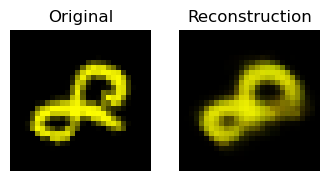

MSE  tensor(10.2379, grad_fn=<MeanBackward1>)


In [28]:
idx = 13456
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()
print('MSE ', ((out.recon_x - x.data)**2).sum(dim = (1,2)).mean(dim = 0))

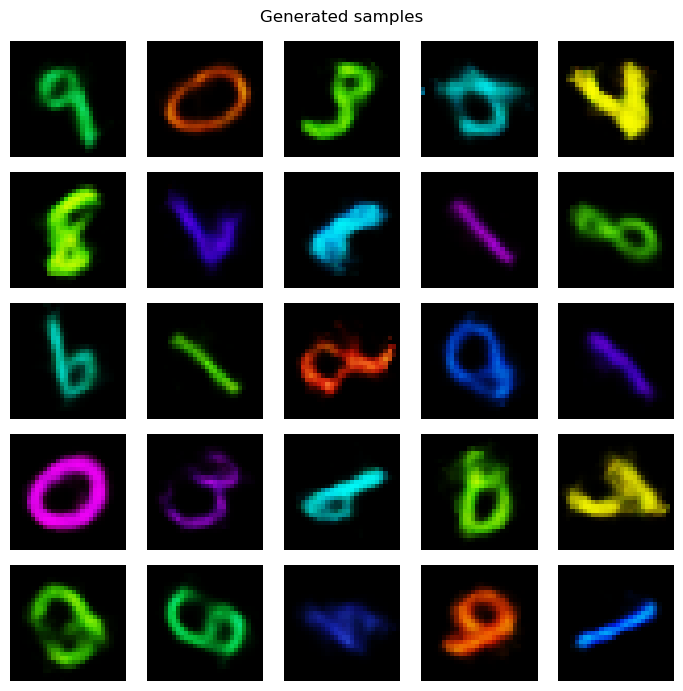

In [29]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0))
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [31]:
n_samples = 100
batch_size = 100

all_z = []

device = 'cpu'
vae = vae.to(device)
mu = mu.to(device)


for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]
all_z = torch.cat(all_z, dim=0).cpu().detach()
all_z.shape

torch.Size([100, 12])

In [32]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=False)
all_logdet_G = []
train_embeddings = []
device = 'cpu'
vae = vae.to(device)
for i, x in enumerate(train_loader):
    x = x.to(device)
    z = vae.encoder(x).embedding
    logdet_G = vae.log_pi(z)
    all_logdet_G.append(logdet_G)
    train_embeddings.append(z)

train_embeddings = torch.cat(train_embeddings, dim=0).cpu().detach()
print(train_embeddings.shape)
all_logdet_G = torch.cat(all_logdet_G).cpu().detach().numpy()
print(all_logdet_G.shape)


torch.Size([64000, 12])
(64000,)


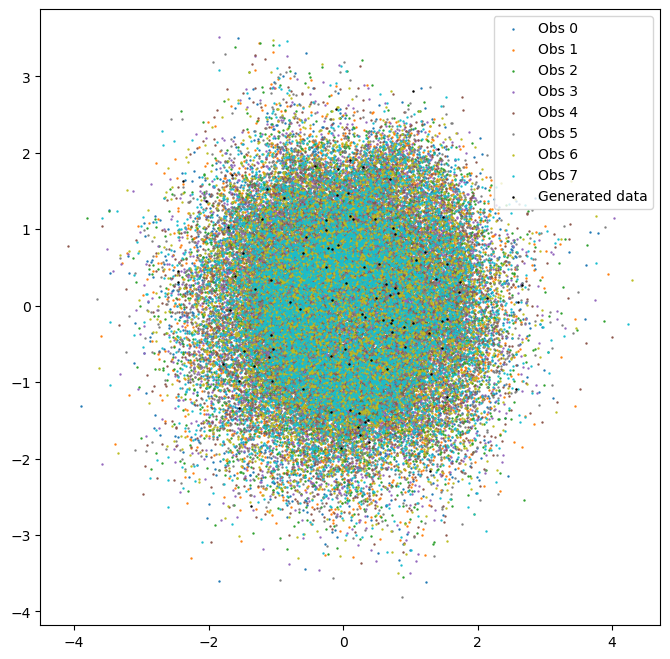

In [38]:
from sklearn.decomposition import PCA

#########
NUM_OBS = 8
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = [7]
#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)
train_embeddings_pca = pca.transform(train_embeddings.detach().numpy())


plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', NUM_OBS)
for i in DISPLAYED_OBS:
    indices = [k % NUM_OBS == i for k in range(train_dataset.data.shape[0])]
    plt.scatter(train_embeddings_pca[indices, 0], train_embeddings_pca[indices, 1], s=0.5, color=colors(i), label=f'Obs {i}')

all_z_pca = pca.transform(all_z.cpu().detach().numpy())

plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 0.6, label='Generated data', c = 'black')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


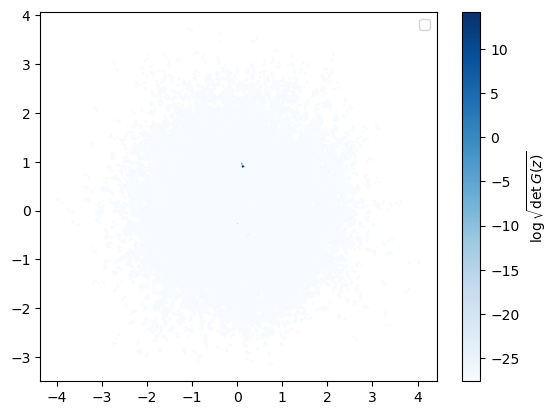

In [34]:
#########
NUM_OBS = 7
DISPLAYED_OBS =  range(NUM_OBS)
PROJECTING_OBS = range(NUM_OBS)

#########
pca = PCA(n_components=2)
indices = [k % NUM_OBS in PROJECTING_OBS for k in range(train_dataset.data.shape[0])]
projection_embeddings = train_embeddings[indices].detach().numpy()
pca.fit(projection_embeddings)

train_pca = pca.transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=all_logdet_G, cmap='Blues', s=1)

plt.legend()
plt.colorbar(label=r'$ \log\sqrt{\det G(z)}$')
plt.show()

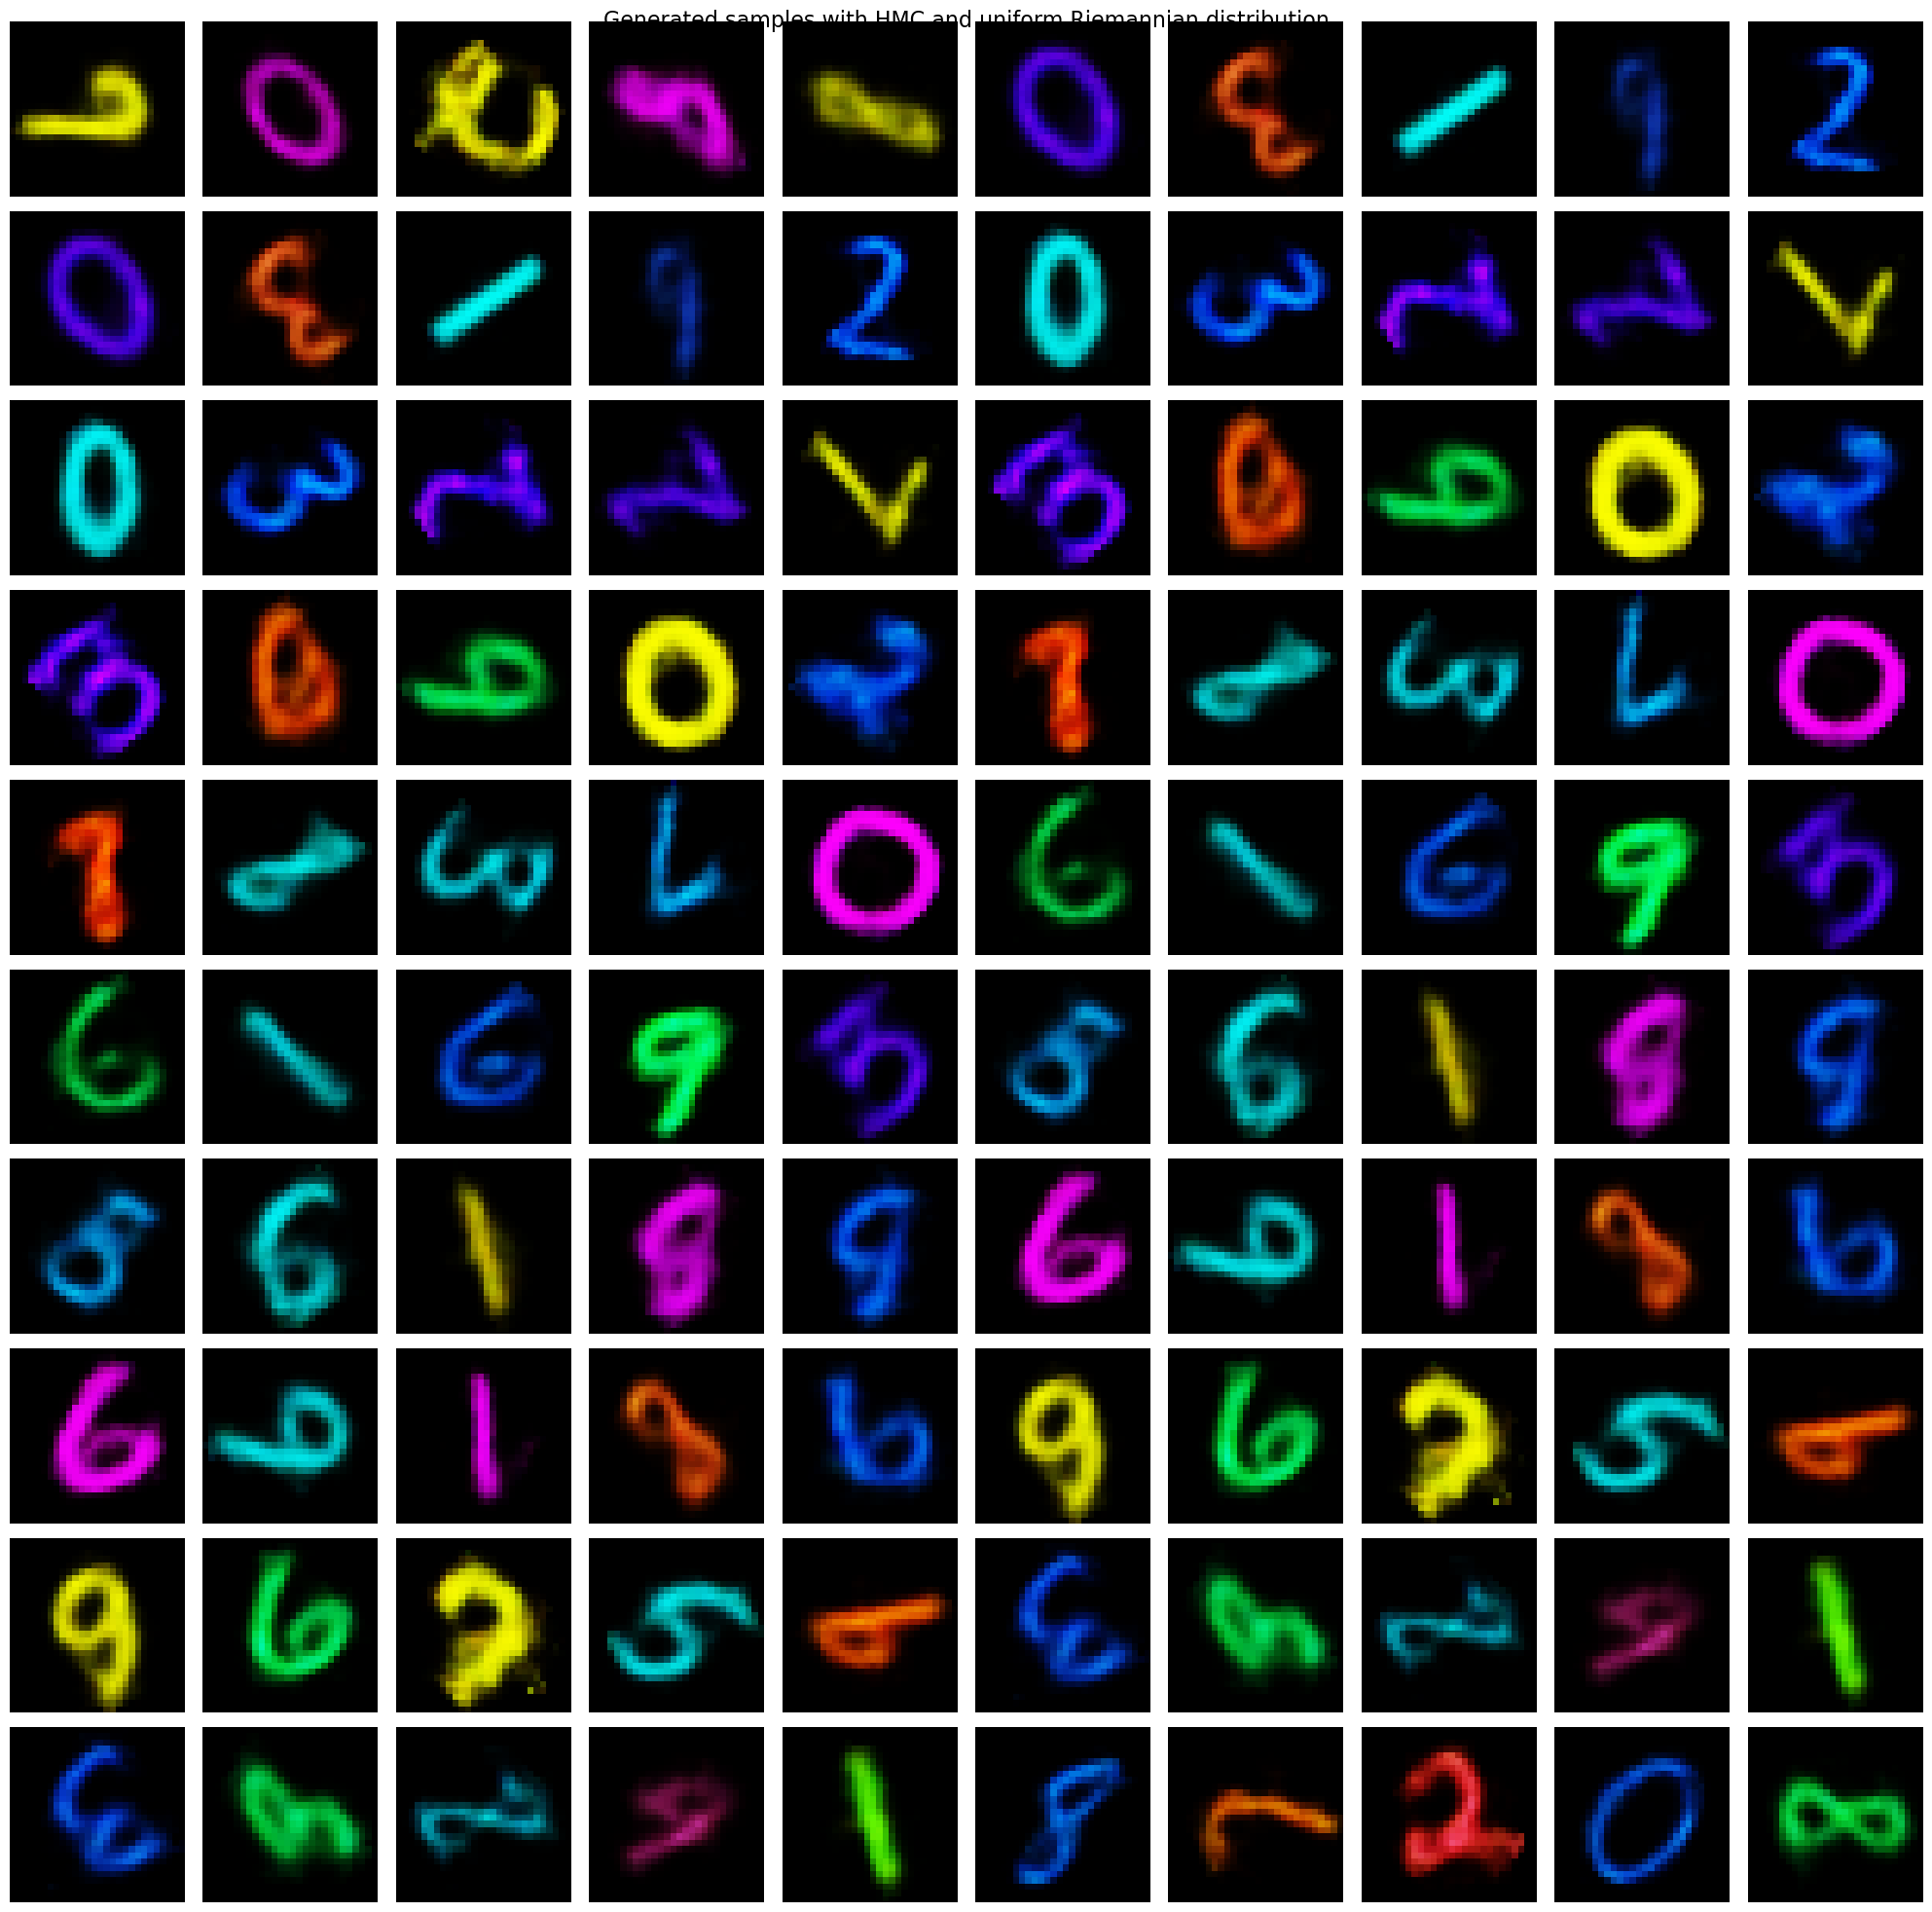

In [35]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()
#new_z = torch.tensor(new_z).to('cpu').detach().float()
last_obs_embeddings = train_embeddings.detach().numpy()
last_obs_embeddings = torch.tensor(last_obs_embeddings).to('cpu').detach().float()


gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0))
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
import geomstats.backend as gs
from geomstats.geometry.manifold import Manifold
from geomstats.geometry.riemannian_metric import RiemannianMetric
from geomstats.numerics.geodesic import ExpODESolver, LogODESolver



class VAEManifold(Manifold):
    r"""Class for the manifold of the latent space of a VAE.

    According to Chadebec and Allassonnière (2021), a trained VAE encodes the input space into a manifold in the latent space, with a specific smooth metric.

    Parameters
    ----------
    dim : int
        Latent dimension
    vae : pythae.models.VAE
        Trained VAE model with built metric
    """

    def __init__(self, dim, vae, threshold_belongs = -20):
        super().__init__(dim, shape=(dim,), equip=True)
        assert dim == vae.latent_dim
        self.vae = vae
        self.threshold_belongs = threshold_belongs


    # Implement the main methods of MyManifold, for example belongs:
    def belongs(self, point, atol=gs.atol):
        """Evaluate if a point in \mathbf{R}^d belongs to the manifold.

        For example: Evaluate if a point belongs to MyManifold.

        In what follows, the ellipsis ... indicates either nothing
        or any number n of elements, i.e. shape=[..., dim] means
        shape=[dim] or shape=[n, dim] for any n.

        Parameters
        ----------
        point : array-like, shape=[..., dim]
            Point to evaluate.
        atol : float
            Tolerance, unused.
            Optional, default: backend atol

        Returns
        -------
        belongs : array-like, shape=[...]
            Boolean evaluating if point belongs to the manifold.
        """

        if len(point.shape) == 1:
            point = point.unsqueeze(0) #from [dim] to [1, dim]

        log_density_point = self.vae.log_pi(point) #shape [n_points]

        belongs = log_density_point > self.threshold_belongs #à voir si c'est la bonne méthode, pcq même pour des training points, la densité est assez basse
        return belongs #shape [n_points] (or [1] if point was [dim])

    # Another example of method of MyManifold.
    def is_tangent(self, vector, base_point=None, atol=gs.atol):
        """Check whether vector is tangent to the manifold at base_point.

        In what follows, the ellipsis ... indicates either nothing
        or any number n of elements, i.e. shape=[..., dim] means
        shape=[dim] or shape=[n, dim] for any n.
        All functions/methods of geomstats should work for any number
        of inputs. In the case of the function `is_tangent`, it means:
        for any number of input vectors.

        Parameters
        ----------
        vector : array-like, shape=[..., dim]
            Vector.
        base_point : array-like, shape=[..., dim]
            Point on the manifold.
        atol : float
            Absolute tolerance threshold

        Returns
        -------
        is_tangent : bool
            Boolean denoting if vector is a tangent vector at the base point.
        """
        #à faire ??



    def to_tangent(self, vector, base_point=None):
        """Project a vector to a tangent space of the manifold.

        Parameters
        ----------
        vector : array-like, shape=[..., dim]
            Vector.
        base_point : array-like, shape=[..., dim]
            Point on the manifold.

        Returns
        -------
        tangent_vec : array-like, shape=[..., dim]
            Tangent vector at base point.
        """
        #on renvoie le vecteur tel quel ??
        return vector
    
    def random_normal_tangent(self, base_point, n_samples=1):
        """Sample in the tangent space from the standard normal distribution.

        Parameters
        ----------
        base_point : array-like, shape=[..., dim]
            Point on the manifold.
        n_samples : int
            Number of samples.
            Optional, default: 1.

        Returns
        -------
        tangent_vec : array-like, shape=[..., dim]
            Tangent vector at base point.
        """
        ambiant_noise = gs.random.normal(
            size=(n_samples, self.embedding_space.dim))
        return self.to_tangent(vector=ambiant_noise, base_point=base_point)

    def random_point(self, n_samples=1):
        """Sample random points on the manifold.

        Parameters
        ----------
        n_samples : int
            Number of samples.
            Optional, default: 1.

        Returns
        -------
        samples : array-like, shape=[..., {dim, [n, n]}]
            Points sampled on the VAE manifold with uniform distribution.
        """

        #simuler selon Markov Chain ?
    
    def default_metric(self):
        return VAEMetric

    def metric_matrix(self, base_point=None):
        return self.metric.metric_matrix(base_point=base_point)
    
    def exp(self, tangent_vec, base_point, **kwargs):
        return self.metric.exp(tangent_vec, base_point, **kwargs)

    
class VAEMetric(RiemannianMetric):
    def metric_matrix(self, base_point=None):
        """Compute the inner-product matrix, independent of the base point.

        Parameters
        ----------
        base_point : array-like, shape=[..., dim]
            Base point.
            Optional, default: None.

        Returns
        -------
        inner_prod_mat : array-like, shape=[..., dim, dim]
            Inner-product matrix.
        """
        return self._space.vae.G_sampl(base_point)


In [20]:
m = vae
torch.manual_seed(8)
generated_data = []

for i in range(1):
    samples = random_walk_batch(
    model=m,
    latent_dim=10,
    n_steps=100,
    n_samples=50,
    verbose=True)

    generated_data.append(samples)

samples = torch.cat(generated_data).detach()
samples.shape

torch.Size([50, 10])
torch.Size([50, 12, 12])


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [50, 12] but got: [50, 10].